In [1]:
!pip install google-cloud-bigquery==1.25.0

     |████████████████████████████████| 169 kB 5.1 MB/s eta 0:00:01
  Attempting uninstall: google-resumable-media
    Found existing installation: google-resumable-media 1.3.2
    Uninstalling google-resumable-media-1.3.2:
      Successfully uninstalled google-resumable-media-1.3.2
  Attempting uninstall: google-cloud-bigquery
    Found existing installation: google-cloud-bigquery 2.23.2
    Uninstalling google-cloud-bigquery-2.23.2:
      Successfully uninstalled google-cloud-bigquery-2.23.2
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
tfx-bsl 1.2.0 requires absl-py<0.13,>=0.9, but you have absl-py 0.13.0 which is incompatible.
tfx-bsl 1.2.0 requires google-api-python-client<2,>=1.7.11, but you have google-api-python-client 2.15.0 which is incompatible.
tfx-bsl 1.2.0 requires google-cloud-bigquery<2.21,>=1.28.0, but you have google-cloud-bigquery 1.25.0 wh

In [2]:
query="""
SELECT
  departure_delay,
  COUNT(1) AS num_flights,
  APPROX_QUANTILES(arrival_delay, 10) AS arrival_delay_deciles
FROM
  `bigquery-samples.airline_ontime_data.flights`
GROUP BY
  departure_delay
HAVING
  num_flights > 100
ORDER BY
  departure_delay ASC
"""
from google.cloud import bigquery
df = bigquery.Client().query(query).to_dataframe()
df.head()

,departure_delay,num_flights,arrival_delay_deciles
0,-37.0,107,"[-66.0, -44.0, -41.0, -35.0, -30.0, -23.0, -17..."
1,-36.0,139,"[-74.0, -43.0, -39.0, -37.0, -32.0, -25.0, -18..."
2,-35.0,191,"[-68.0, -45.0, -40.0, -36.0, -28.0, -19.0, -14..."
3,-34.0,195,"[-58.0, -44.0, -40.0, -35.0, -30.0, -25.0, -19..."
4,-33.0,227,"[-59.0, -43.0, -39.0, -36.0, -32.0, -28.0, -20..."


In [3]:
import pandas as pd
percentiles = df['arrival_delay_deciles'].apply(pd.Series)
percentiles = percentiles.rename(columns = lambda x : str(x*10) + "%")
df = pd.concat([df['departure_delay'], percentiles], axis=1)
df.head()

,departure_delay,0%,10%,20%,30%,40%,50%,60%,70%,80%,90%,100%
0,-37.0,-66.0,-44.0,-41.0,-35.0,-30.0,-23.0,-17.0,-12.0,-3.0,6.0,33.0
1,-36.0,-74.0,-43.0,-39.0,-37.0,-32.0,-25.0,-18.0,-14.0,-7.0,2.0,49.0
2,-35.0,-68.0,-45.0,-40.0,-36.0,-28.0,-19.0,-14.0,-8.0,-4.0,3.0,85.0
3,-34.0,-58.0,-44.0,-40.0,-35.0,-30.0,-25.0,-19.0,-14.0,-8.0,2.0,39.0
4,-33.0,-59.0,-43.0,-39.0,-36.0,-32.0,-28.0,-20.0,-14.0,-7.0,5.0,25.0


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:1: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only
  """Entry point for launching an IPython kernel.


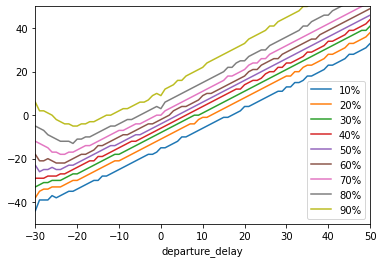

In [4]:
without_extremes = df.drop(['0%', '100%'], 1)
without_extremes.plot(x='departure_delay', xlim=(-30,50), ylim=(-50,50));